# Music Reccomendatation System

In [13]:
import gzip
import tarfile
import io
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import random

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Section 1: Task Definition

### Task: We want to predict whether users would enjoy a certain song (reccomendation)

- Given: Musical features of a new song with no historical data
- Predict: Top-K users most likely to enjoy a certain song

### Why does this matter?

- Music platforms add 60,000+ songs daily (Spotify)
- New artists need exposure immediately
- Cannot wait weeks for interaction data to accumulate
- 40% of music discovery happens through recommendations

### Evaluation Metrics

- MAP@K (Mean Average Precision): Rewards correct users ranked higher
- Recall@K: Fraction of relevant users retrieved in top-K
- NDCG@K: Normalized Discounted Cumulative Gain
- Coverage: % of users/songs system can recommend

### Baselines for Comparison

1. Random: Randomly select users (sanity check)
2. Popularity: Recommend to most active users (ignores content)
3. Genre-Based: Match song genre to user preferences
4. Content-Based: Cosine similarity between song and user profiles
5. k-NN: Find similar training songs, recommend their users
6. Matrix Factorization: Learn latent factors from content

### Validation Strategy

- Temporal split: 80% train, 20% test songs (simulate new releases)
- Cold-start simulation: Test songs have ZERO training interactions
- Cross-validation for hyperparameter tuning on training set
- Statistical significance testing (paired t-tests)

## Dataset Preprocessing and Analysis

### Dataset

We are using the PDMX (Public Domain MusicXML) dataset. It contains symbolic music files with rich metadata including pitch_class entropy, complexity, and groove_consistency. With this data, we hope to predict whether a user would enjoy a certain song recommended by the system. Rather than using a dataset that used actual music data, we wanted to test to see whether only music features would make do.

Dataset download link: 
https://zenodo.org/records/13763756/files/PDMX.tar.gz?download=1

### Preprocessing

1. Extraction
2. Feature Selection
3. Interaction Generation

In [ ]:
file_path = "dataset/PDMX.tar.gz"

with tarfile.open(file_path, mode="r:gz") as tar_file:
    for member in tar_file.getmembers():
        if member.isfile() and member.name.endswith('.csv'):
            f = tar_file.extractfile(member)
            
            df = pd.read_csv(io.BytesIO(f.read()))

In [16]:
df.head()

,path,metadata,has_metadata,version,is_user_pro,is_user_publisher,is_user_staff,has_paywall,is_rated,is_official,...,best_path,is_best_path,best_arrangement,is_best_arrangement,best_unique_arrangement,is_best_unique_arrangement,subset:all,subset:rated,subset:deduplicated,subset:rated_deduplicated
0,./data/b/b/QmbbGKtZ9G6DkWxvSeU516c1ktWiFJmEbHG...,./metadata/5/5740212.json,True,3.01,True,False,False,False,True,False,...,/data2/zachary/musescore/data/b/b/QmbbGKtZ9G6D...,True,/data2/zachary/musescore/data/b/b/QmbbGKtZ9G6D...,True,/data2/zachary/musescore/data/b/b/QmbbGKtZ9G6D...,True,True,True,True,True
1,./data/b/b/QmbbWCwo3rhaJ2wKL6H7aQPX9D6HfQxLZKP...,./metadata/2/5736259.json,True,3.01,True,False,False,False,False,False,...,/data2/zachary/musescore/data/W/S/QmWSaF8DyssR...,False,/data2/zachary/musescore/data/e/F/QmeFmHKn3UF4...,False,/data2/zachary/musescore/data/e/F/QmeFmHKn3UF4...,False,True,False,False,False
2,./data/b/b/QmbbhLwwmuKqA9MC1ULhojEMGxnxDobsZPJ...,./metadata/1/4571401.json,True,3.01,True,False,False,False,False,False,...,/data2/zachary/musescore/data/Y/T/QmYTrMnu1wWn...,False,/data2/zachary/musescore/data/a/a/QmaahMHX51Jm...,False,/data2/zachary/musescore/data/a/a/QmaahMHX51Jm...,False,True,False,False,False
3,./data/b/b/Qmbbh58jD1ZLT1vevNsnyEZkexnx2USTFz6...,./metadata/6/4694088.json,True,3.01,True,False,False,False,False,False,...,/data2/zachary/musescore/data/V/2/QmV2RMMZuHxh...,False,/data2/zachary/musescore/data/V/2/QmV2RMMZuHxh...,False,/data2/zachary/musescore/data/V/2/QmV2RMMZuHxh...,False,True,False,False,False
4,./data/b/b/Qmbbmnu3Eg81nQ3WHnBFrAj5gsr3D13ysSQ...,./metadata/4/4808199.json,True,3.01,True,False,False,False,False,False,...,/data2/zachary/musescore/data/f/5/Qmf5QQhwvkXM...,False,/data2/zachary/musescore/data/f/5/Qmf5QQhwvkXM...,False,/data2/zachary/musescore/data/f/5/Qmf5QQhwvkXM...,False,True,False,False,False


In [21]:
# Filter NaN genres
df['genres'] = df['genres'].fillna('Unknown')

# Normalize numerical features
feature_cols = ['complexity', 'pitch_class_entropy', 'scale_consistency', 'groove_consistency']

# Handle missing values in features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [22]:
print(df[feature_cols].describe())

          complexity  pitch_class_entropy  scale_consistency  \
count  254077.000000        254077.000000      254077.000000   
mean        0.244083             0.751271           0.930824   
std         0.174533             0.070856           0.122505   
min         0.000000             0.000000           0.000000   
25%         0.000000             0.714415           0.911765   
50%         0.333333             0.748727           0.990864   
75%         0.333333             0.784391           1.000000   
max         1.000000             1.000000           1.000000   

       groove_consistency  
count       254077.000000  
mean             0.899942  
std              0.059335  
min              0.000000  
25%              0.872917  
50%              0.911765  
75%              0.940000  
max              1.000000  


### Generating User-item Interactions

The PDMX dataset provides the counts of favorites (in n_favorites), but doesn't provide the users who favorited them. In order to perform User-Item reccomendation, we must simulate these interactions. To do this, we assume that users have specific tastes.

1. Create pool of 500 syntheic users
2. Users assigned with "preferred complexity" and "preferred genre"
3. Distribute n_favorites of a song to users who statistically match the song's features

In [25]:
np.random.seed(42)
n_users = 500
user_ids = [f'u_{i}' for i in range(n_users)]

user_profiles_ground_truth = []
for u in user_ids:
    user_profiles_ground_truth.append({
        'user_id': u,
        'pref_complexity': np.random.uniform(0, 1), 
        'pref_entropy': np.random.uniform(0, 1),  
        'activity_level': np.random.beta(2, 5)   
    })
df_users = pd.DataFrame(user_profiles_ground_truth)

interactions = []

print("Generating interactions based on n_favorites...")
for idx, song in df.iterrows():
    n_favs = int(song['n_favorites'])
    if n_favs == 0: continue
        
    # Calculate probability of each user liking this song based on Feature Similarity
    dist = (abs(df_users['pref_complexity'] - song['complexity']) + 
            abs(df_users['pref_entropy'] - song['pitch_class_entropy']))
    
    # Probability ~ 1 / (1 + Distance) * User_Activity
    probs = (1 / (1 + dist)) * df_users['activity_level']
    probs = probs / probs.sum() 
    
    chosen_users = np.random.choice(
        df_users['user_id'], 
        size=min(n_favs, n_users), 
        replace=False, 
        p=probs
    )
    
    for u in chosen_users:
        interactions.append({'user_id': u, 'song_id': idx, 'liked': 1})

df_interactions = pd.DataFrame(interactions)
print(f"Generated {len(df_interactions)} interactions.")

Generating interactions based on n_favorites...
Generated 914634 interactions.


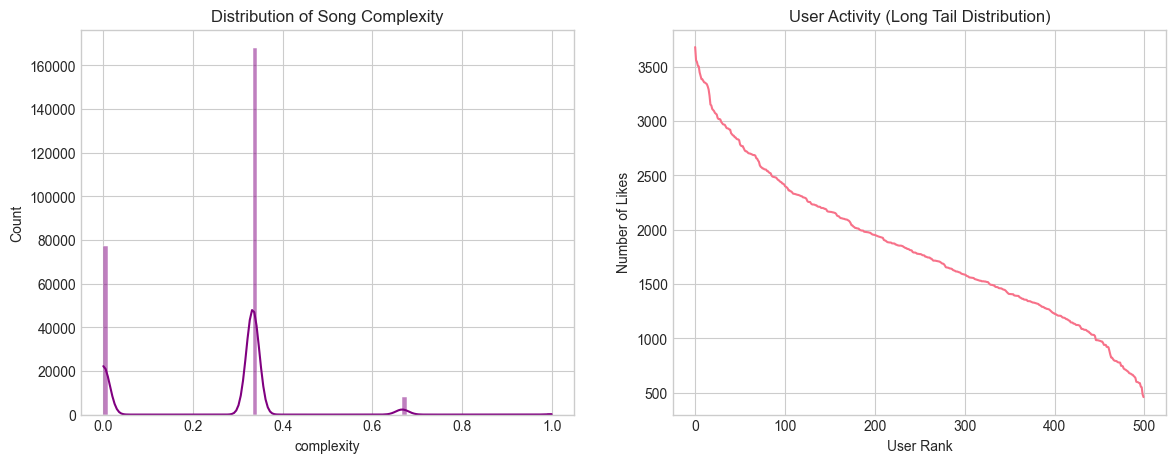

In [26]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['complexity'], kde=True, color='purple')
plt.title('Distribution of Song Complexity')

plt.subplot(1, 2, 2)

user_counts = df_interactions['user_id'].value_counts()
plt.plot(user_counts.values)
plt.title('User Activity (Long Tail Distribution)')
plt.xlabel('User Rank')
plt.ylabel('Number of Likes')
plt.show()